In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

annotations_path = '/content/drive/MyDrive/Research_work_prathyush/p_labels.csv'
annotations = pd.read_csv(annotations_path)

image_dir = '/content/drive/MyDrive/Research_work_prathyush/content/download_images'

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

#image data
image_paths = [os.path.join(image_dir, fname) for fname in annotations['image']]
images = np.array([load_and_preprocess_image(fpath) for fpath in image_paths])

#labels
rating_to_label = {rating: i for i, rating in enumerate(annotations['rating'].unique())}
label_to_rating = {i: rating for rating, i in rating_to_label.items()}
labels = np.array(annotations['rating'].replace(rating_to_label))

In [ ]:
rating_to_label

{'Very Poor': 0, 'Very Good': 1, 'Poor': 2, 'Good': 3, 'Fair': 4}

In [ ]:
data = pd.DataFrame({'image_path': image_paths, 'label': labels})
max_samples = data['label'].value_counts().max()

#resampling
resampled_data = []
for label in data['label'].unique():
    label_data = data[data['label'] == label]
    resampled_label_data = resample(label_data, replace=True, n_samples=max_samples, random_state=42)
    resampled_data.append(resampled_label_data)

balanced_data = pd.concat(resampled_data)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Load the balanced image data and labels
balanced_image_paths = balanced_data['image_path'].tolist()
balanced_images = np.array([load_and_preprocess_image(fpath) for fpath in balanced_image_paths])
balanced_labels = balanced_data['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

Total balanced images: 3875
Training images: 3100
Validation images: 775
Label distribution in training set: [621 616 628 608 627]
Label distribution in validation set: [154 159 147 167 148]


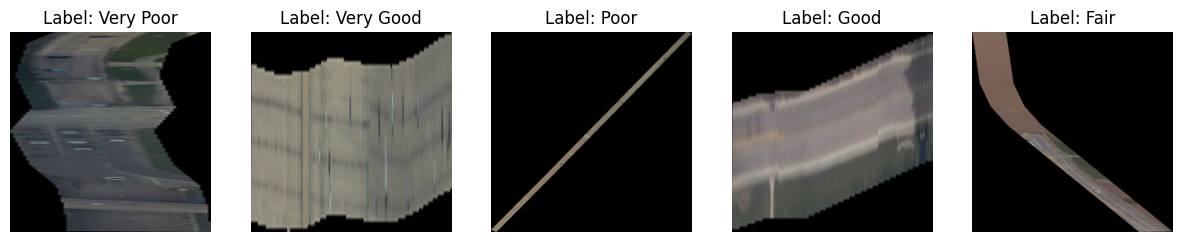

In [ ]:
import matplotlib.pyplot as plt

def plot_sample_images(balanced_images, balanced_labels, label_to_rating, num_samples_per_class=1):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        for j in range(min(num_samples_per_class, len(label_indices))):
            plt.subplot(1, len(unique_labels), i + 1)
            plt.imshow(images[label_indices[j]])
            plt.title(f'Label: {label_to_rating[label]}')
            plt.axis('off')
    plt.show()

plot_sample_images(X_train, y_train, label_to_rating)

print(f'Total balanced images: {len(balanced_images)}')
print(f'Training images: {len(X_train)}')
print(f'Validation images: {len(X_val)}')
print(f'Label distribution in training set: {np.bincount(y_train)}')
print(f'Label distribution in validation set: {np.bincount(y_val)}')

# MobileNetV2 - 2nd Top Performing Model -2018

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

model.summary()

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
97/97 [==============================] - 8s 53ms/step - loss: 1.3770 - accuracy: 0.4874 - val_loss: 1.0590 - val_accuracy: 0.6142
Epoch 2/20
97/97 [==============================] - 3s 35ms/step - loss: 0.8305 - accuracy: 0.6977 - val_loss: 0.7721 - val_accuracy: 0.7239
Epoch 3/20
97/97 [==============================] - 3s 35ms/step - loss: 0.6593 - accuracy: 0.7632 - val_loss: 0.6318 - val_accuracy: 0.7832
Epoch 4/20
97/97 [==============================] - 3s 35ms/step - loss: 0.5561 - accuracy: 0.8177 - val_loss: 0.5497 - val_accuracy: 0.8129
Epoch 5/20
97/97 [==============================] - 3s 35ms/step - loss: 0.4808 - accuracy: 0.8416 - val_loss: 0.5378 - val_accuracy: 0.8206
Epoch 6/20
97/97 [==============================] - 3s 35ms/step - loss: 0.4364 - accuracy: 0.8648 - val_loss: 0.4890 - val_accuracy: 0.8426
Epoch 7/20
97/97 [==============================] - 3s 35ms/step - loss: 0.3844 - accuracy:

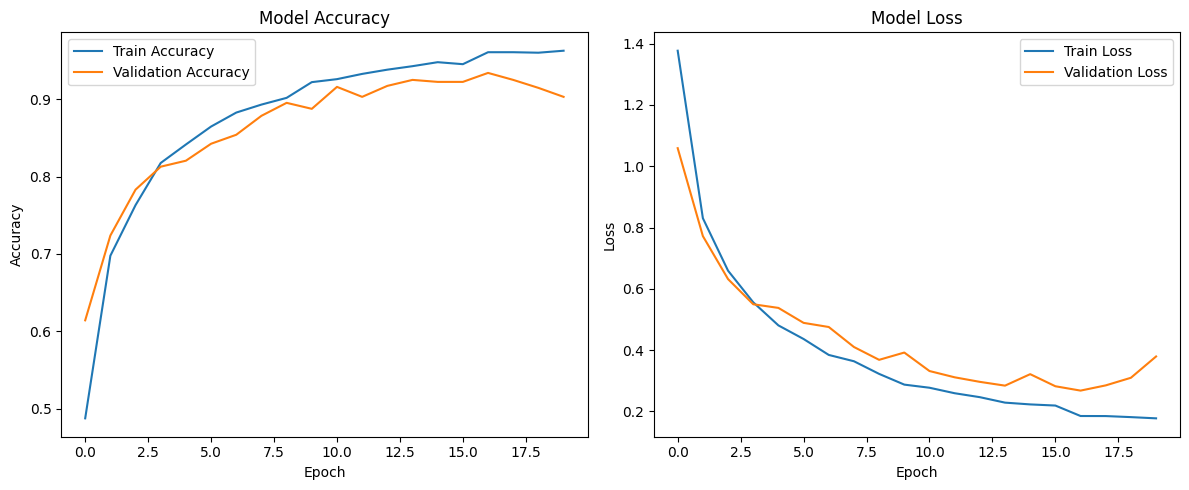

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

25/25 [==============================] - 1s 24ms/step


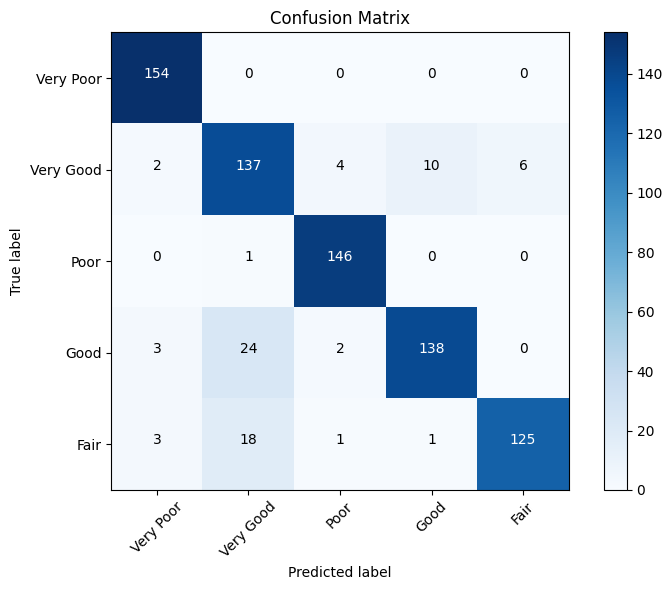

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Very Poor','Very Good','Poor','Good','Fair']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

#EfficientNetB0 -2019





In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model1.trainable = False

model1 = Sequential([
    base_model1,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model1.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = model1.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         2949376   
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
  (GlobalAveragePooling2D)                             

# RegNetX Model -2023

In [ ]:
from tensorflow.keras.applications import RegNetX002
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model2 = RegNetX002(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2.trainable = False

model2 = Sequential([
    base_model2,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model2.compile(optimizer=Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model2.summary()

history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = model2.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")


9797576/9797576 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 regnetx002 (Functional)     (None, 7, 7, 368)         2336640   
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 368)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         848128    
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_1  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                         

# ConvNeXt Model -2023


In [ ]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model3 = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model3.trainable = False

model3 = Sequential([
    base_model3,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])


model3.compile(optimizer=Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model3.summary()

history3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
loss, accuracy = model3.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 dropout (Dropout)           (None, 7, 7, 768)         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1769728   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 256)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

# EfficientNetV2B0 -2022

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model4 = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model4.trainable = False

model4 = Sequential([
    base_model4,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model4.compile(optimizer=Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model4.summary()
history4 = model4.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
loss, accuracy = model4.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2949376   
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                      

# MobileNetV3Large -2021 3rd Top Performing Model

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


base_model5 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model5.trainable = False


model5 = Sequential([
    base_model5,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model5.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()
history = model5.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = model5.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 960)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 256)         2212096   
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_5  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                      

# ResNet50V2 -2020 The best Performing Model




In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model6 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model6.trainable = False  # Freeze the base model

model6 = Sequential([
    base_model6,
    Dropout(0.2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.003))
])

model6.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model6.summary()

history6 = model6.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = model6.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")


94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_16 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 256)         4718848   
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_8  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                       

25/25 [==============================] - 2s 46ms/step


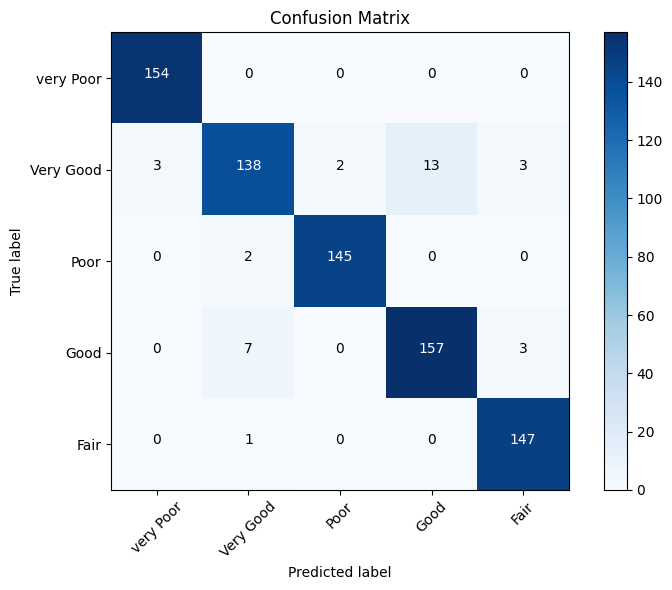

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model6.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['very Poor','Very Good','Poor','Good','Fair']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()